In [2]:
import jax
from jax import config

import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import cm

In [7]:
def cdf_img(x, b = 0.25):
    u = jnp.sort(x.ravel())
    neg = jnp.sum(u<0)
    nneg = u.shape[0] - neg
    v = jnp.concatenate((jnp.linspace(-1,-b,neg), jnp.linspace(b,1,nneg)), axis=0)
    y = jnp.interp(x, u, v)
    return y

def conv_measure(v, max=1e6):
    v = jnp.abs(v)
    fin = jnp.isfinite(v)
    v = v*fin + max*(1 - fin)
    v /= 2
    ex = (v > max)
    v = v*(1 - ex) + max*ex
    conv = (jnp.mean(v[-20:]) < 1)
    return jnp.where(conv, -jnp.sum(v), jnp.sum(1/v))


In [4]:
def mandel_traj(c, num):
    def mandel_z(z,step):
        zz = z**2 + c
        return zz, zz
    
    z = 0+0j
    zf,zh = jax.lax.scan(mandel_z, z, jnp.arange(num))
    return zh

def mandel_traj_summ(c, num):
    zh = mandel_traj(c, num)
    return conv_measure(zh)

mandel_traj_summ_map = jax.jit(jax.vmap(mandel_traj_summ, in_axes=(0,None), out_axes=0),static_argnums=(1,))

def mandel_image(c0,c1,res,numc=64):
    cr,ci=jnp.meshgrid(jnp.linspace(c0.real,c1.real,res), jnp.linspace(c0.imag, c1.imag,res))
    C = cr + 1j * ci
    C = C.reshape((numc, -1))
    img = []
    for cc in C:
        ic = mandel_traj_summ_map(cc, 100)
        img.append(ic)
    
    img = jnp.concatenate(img, axis=0)
    return img.reshape((res,res))

In [6]:
c0 = -2.1 - 1.35j
c1 = 0.6 + 1.35j
res = 128*4
img = mandel_image(c0,c1,res)

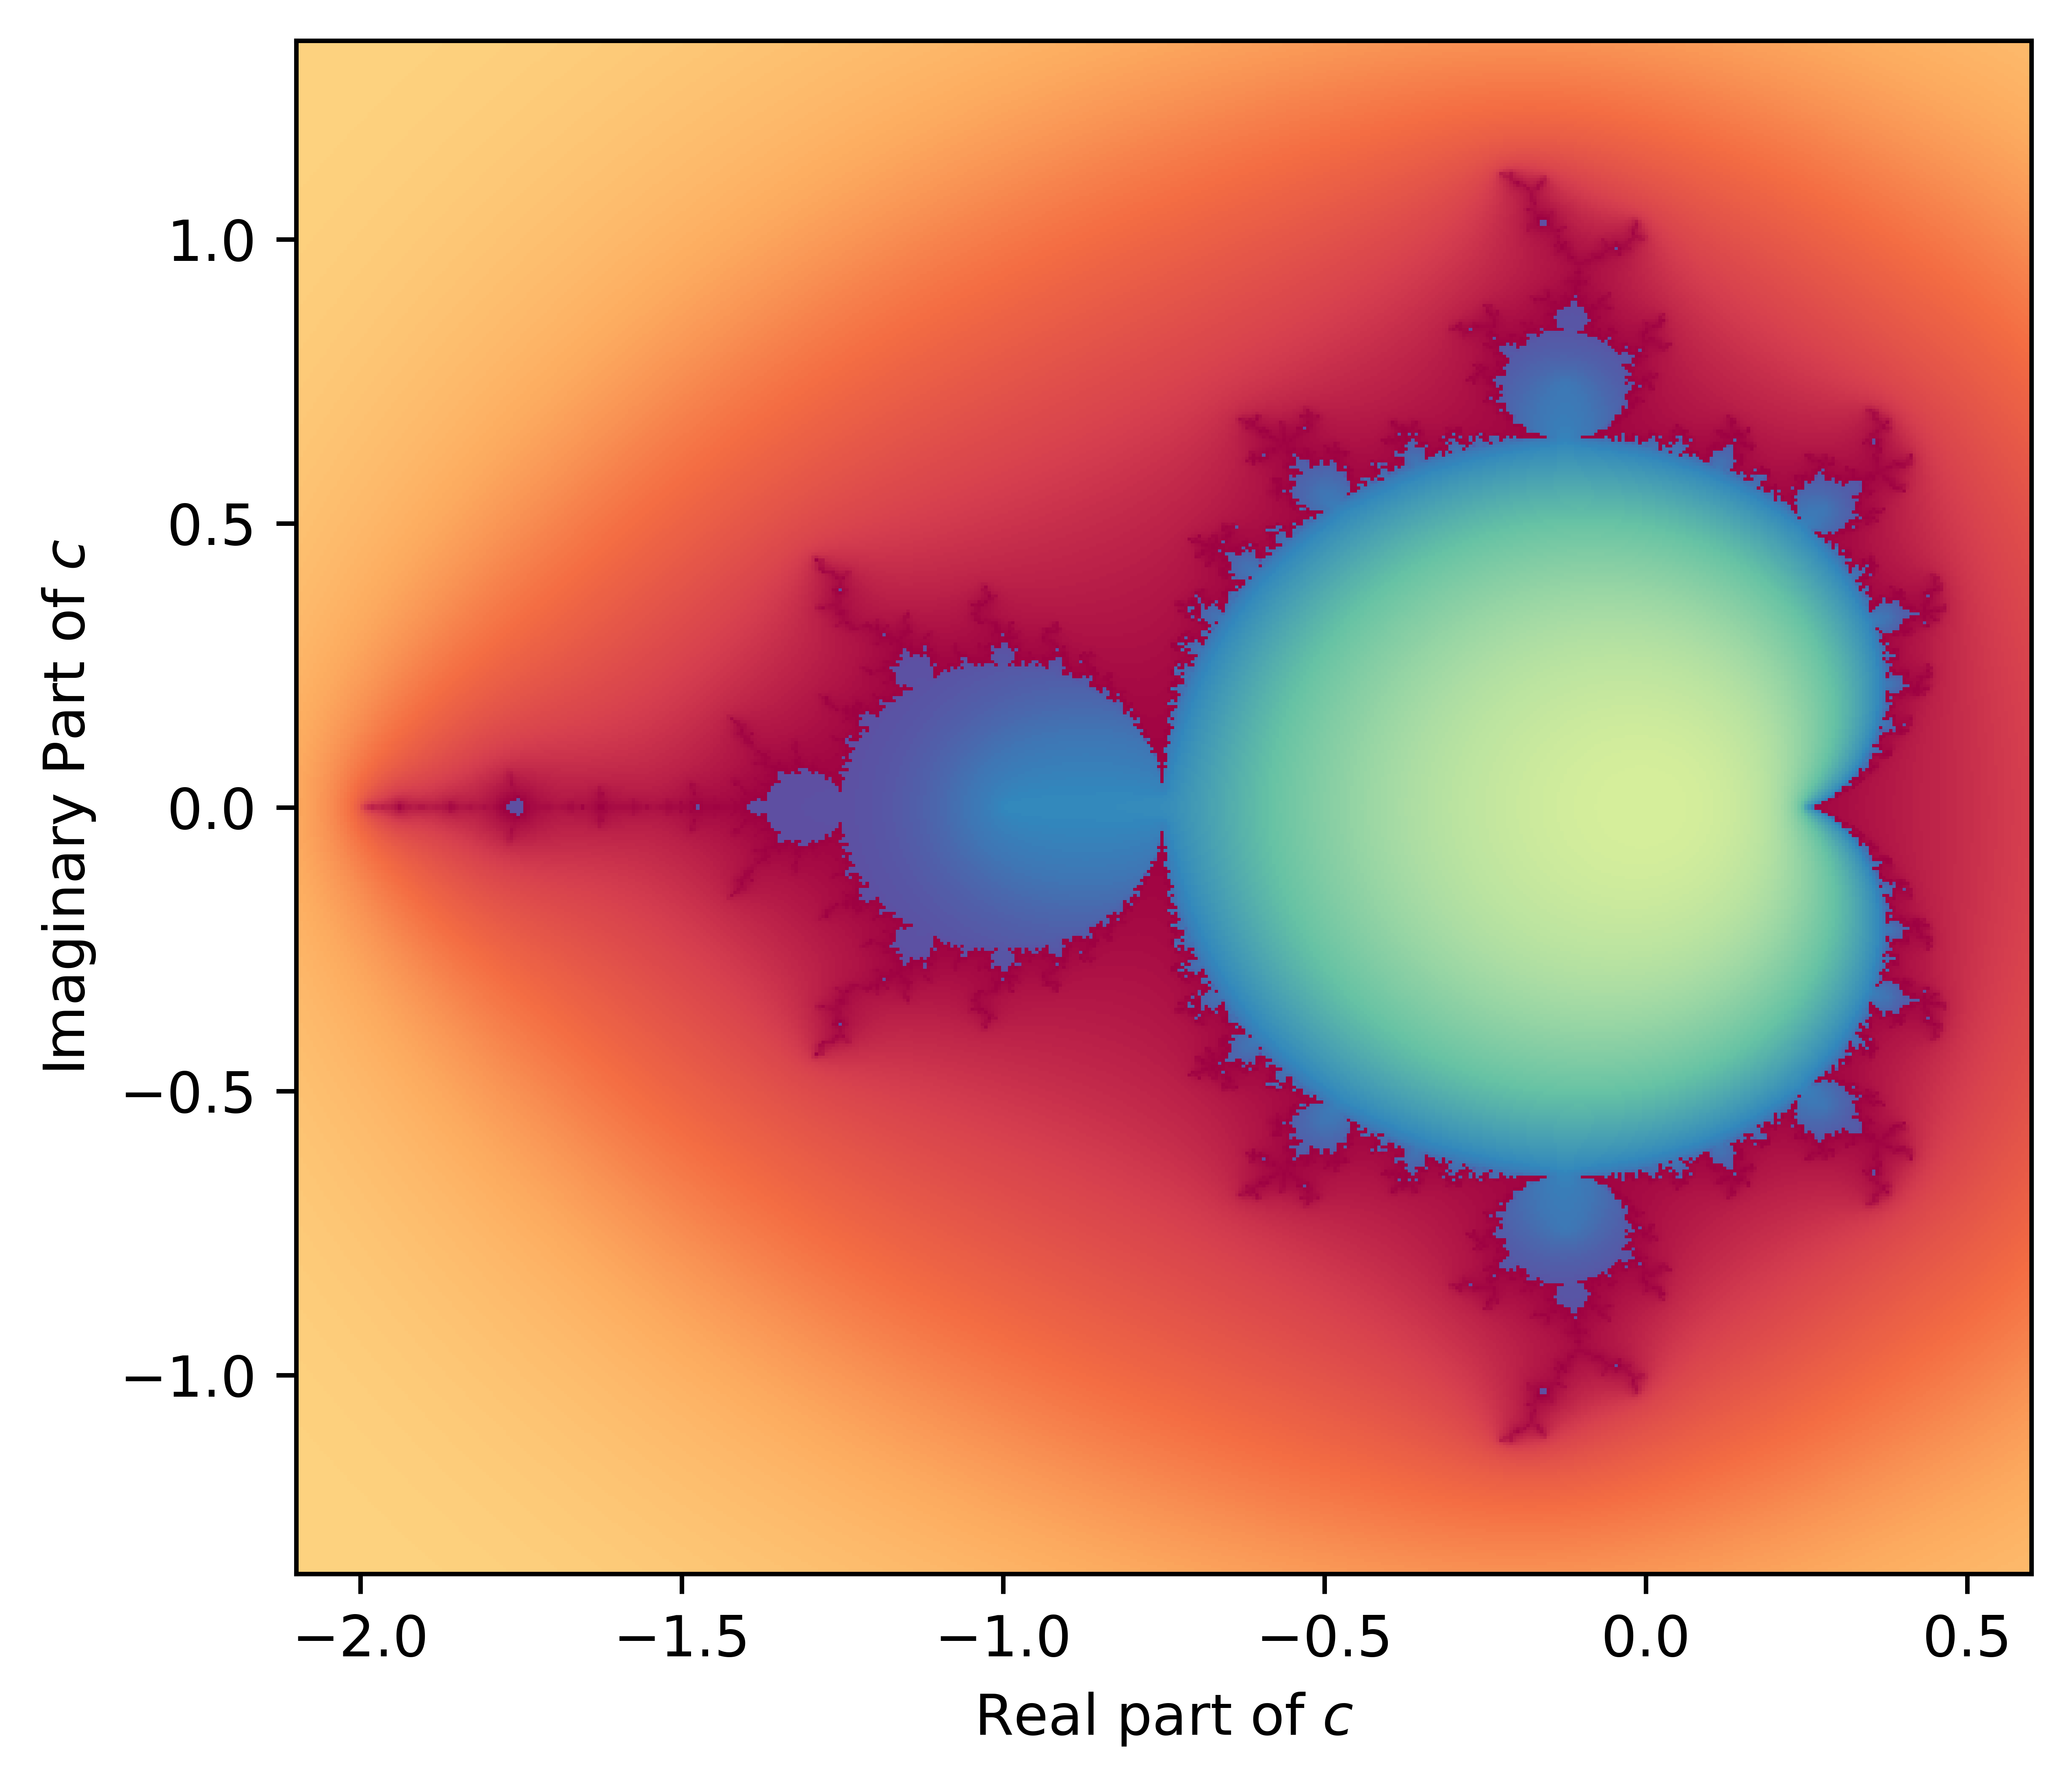

In [8]:
dpi = 1000
figsize = (5.2,4.5)
imgn = cdf_img(-img)
fig, (ax1) = plt.subplots(figsize=figsize, dpi=dpi)
im = ax1.imshow(imgn, 
                extent=[c0.real, c1.real, c0.imag, c1.imag],
                origin='lower',
                vmin=-1,vmax=1, 
                cmap='Spectral',
                aspect='auto',
                interpolation='nearest'
                )

plt.xlabel(r'Real part of $c$')
plt.ylabel(r'Imaginary Part of $c$')

plt.tight_layout()

plt.savefig('mandelbrot.pdf')
plt.savefig('mandelbrot.png')
